# Test `xesmf`

Follows the introductory tutorial for [`xesmf`](https://xesmf.readthedocs.io/en/latest/notebooks/Rectilinear_grid.html)

https://climatedataguide.ucar.edu/climate-data-tools-and-analysis/regridding-overview  

https://www.ncl.ucar.edu/Applications/ESMF.shtml

https://xgcm.readthedocs.io/en/latest/index.html

http://www.earthsystemmodeling.org/esmf_releases/public/ESMF_8_0_0/esmpy_doc/html/index.html

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe

We use xarrays example air temperature data set

In [3]:
ds = xr.tutorial.open_dataset('air_temperature') # use xr.tutorial.load_dataset() for xarray<v0.11.0
ds

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

The dataset is a 2.5 by 2.5 degree grid over North America

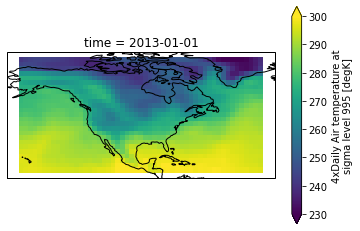

In [4]:
dr = ds['air']  # get a DataArray
ax = plt.axes(projection=ccrs.PlateCarree())
dr.isel(time=0).plot.pcolormesh(ax=ax, vmin=230, vmax=300);
ax.coastlines();

In [5]:
dr.lat

<xarray.DataArray 'lat' (lat: 25)>
array([75. , 72.5, 70. , 67.5, 65. , 62.5, 60. , 57.5, 55. , 52.5, 50. , 47.5,
       45. , 42.5, 40. , 37.5, 35. , 32.5, 30. , 27.5, 25. , 22.5, 20. , 17.5,
       15. ], dtype=float32)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
Attributes:
    standard_name:  latitude
    long_name:      Latitude
    units:          degrees_north
    axis:           Y

In [6]:
dr.lon

<xarray.DataArray 'lon' (lon: 53)>
array([200. , 202.5, 205. , 207.5, 210. , 212.5, 215. , 217.5, 220. , 222.5,
       225. , 227.5, 230. , 232.5, 235. , 237.5, 240. , 242.5, 245. , 247.5,
       250. , 252.5, 255. , 257.5, 260. , 262.5, 265. , 267.5, 270. , 272.5,
       275. , 277.5, 280. , 282.5, 285. , 287.5, 290. , 292.5, 295. , 297.5,
       300. , 302.5, 305. , 307.5, 310. , 312.5, 315. , 317.5, 320. , 322.5,
       325. , 327.5, 330. ], dtype=float32)
Coordinates:
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
Attributes:
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east
    axis:           X

As an example we will downscale this grid to a 1 by 1.5 degree grid.  This new output grid needs to be defined.

In [7]:
ds_out = xr.Dataset({
    'lat': (['lat'], np.arange(16, 75, 1.0)),
    'lon': (['lon'], np.arange(200, 330, 1.5)),
    })
ds_out

<xarray.Dataset>
Dimensions:  (lat: 59, lon: 87)
Coordinates:
  * lat      (lat) float64 16.0 17.0 18.0 19.0 20.0 ... 70.0 71.0 72.0 73.0 74.0
  * lon      (lon) float64 200.0 201.5 203.0 204.5 ... 324.5 326.0 327.5 329.0
Data variables:
    *empty*

# Regridding

Regridding is performed by a `xesmg.Regridder` object, which takes the input grid, output grid and a regrdding method as arguments.

In [8]:
xe.Regridder?

Init signature:
xe.Regridder(
    ds_in,
    ds_out,
    method,
    periodic=False,
    filename=None,
    reuse_weights=False,
    ignore_degenerate=None,
    locstream_in=False,
    locstream_out=False,
)
Docstring:      <no docstring>
Init docstring:
Make xESMF regridder

Parameters
----------
ds_in, ds_out : xarray DataSet, or dictionary
    Contain input and output grid coordinates. Look for variables
    ``lon``, ``lat``, and optionally ``lon_b``, ``lat_b`` for
    conservative method.

    Shape can be 1D (n_lon,) and (n_lat,) for rectilinear grids,
    or 2D (n_y, n_x) for general curvilinear grids.
    Shape of bounds should be (n+1,) or (n_y+1, n_x+1).

method : str
    Regridding method. Options are

    - 'bilinear'
    - 'conservative', **need grid corner information**
    - 'patch'
    - 'nearest_s2d'
    - 'nearest_d2s'

periodic : bool, optional
    Periodic in longitude? Default to False.
    Only useful for global grids with non-conservative regridding.
    Will be f

In [9]:
regridder = xe.Regridder(ds, ds_out, 'bilinear')
regridder

Create weight file: bilinear_25x53_59x87.nc


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_25x53_59x87.nc 
Reuse pre-computed weights? False 
Input grid shape:           (25, 53) 
Output grid shape:          (59, 87) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

This allows multiple fields to be regridded using the same regridder.

In [10]:
dr_out = regridder(dr)
dr_out

<xarray.DataArray 'air' (time: 2920, lat: 59, lon: 87)>
array([[[296.13399675, 296.38669304, 296.63889823, ..., 296.47490793,
         296.43398913, 296.19924566],
        [295.97800871, 296.18274797, 296.42534501, ..., 296.09262341,
         296.07802394, 295.72098714],
        [296.04001766, 296.13556275, 296.30247974, ..., 295.77692914,
         295.73997197, 295.35693248],
        ...,
        [245.04017912, 245.36087049, 245.56096188, ..., 233.93629106,
         235.51802332, 238.0780694 ],
        [243.27991042, 243.77519503, 244.17375053, ..., 233.81591274,
         235.33999633, 237.63241841],
        [242.24003289, 242.87912303, 243.43775032, ..., 233.84791841,
         235.41999207, 237.49641598]],

       [[296.25399643, 296.70203773, 297.03166485, ..., 296.06514956,
         296.03998263, 296.01773136],
        [296.2179898 , 296.56767711, 296.82291528, ..., 295.7292558 ,
         295.6800262 , 295.5138904 ],
        [296.23999022, 296.42058286, 296.56714652, ..., 295.50442291,
         295.41998903, 295.19133215],
        ...,
        [245.52028453, 245.73709231, 245.85148963, ..., 231.64759509,
         232.67802699, 234.83033953],
        [243.29994515, 243.61404829, 243.85326489, ..., 231.80653129,
         232.72003168, 234.51923375],
        [242.70001369, 243.03800427, 243.31726258, ..., 232.22256285,
         233.15997775, 234.71925176]],

       [[296.31998597, 296.35233477, 296.37027072, ..., 296.69703874,
         296.59998477, 296.42993717],
        [296.23999022, 296.37072264, 296.42865111, ..., 296.39312798,
         296.20003046, 295.98447426],
        [296.07996829, 296.20134835, 296.24744824, ..., 296.17051878,
         295.85798008, 295.63218076],
        ...,
        [246.92034241, 246.75294557, 246.50912779, ..., 231.18562131,
         232.24003595, 234.61904532],
        [244.13992017, 244.03040136, 243.89556811, ..., 231.78222568,
         232.82012307, 234.90301222],
        [243.22002405, 243.13672999, 243.05876072, ..., 233.39835074,
         234.45993206, 236.27912467]],

       ...,

       [[297.62998356, 298.25582152, 298.65503226, ..., 295.7786526 ,
         295.66999665, 295.50299763],
        [297.07004997, 297.7199817 , 298.19914665, ..., 295.58670885,
         295.55000304, 295.2150872 ],
        [296.38994762, 296.98154159, 297.52424514, ..., 295.48204978,
         295.46998597, 295.05016151],
        ...,
        [251.81041188, 251.72296686, 251.55990593, ..., 240.75713161,
         241.37000425, 242.46456685],
        [247.96982451, 247.87036819, 247.69574495, ..., 241.55307104,
         241.93009016, 242.64624471],
        [245.73007797, 245.53418764, 245.25570503, ..., 242.92917313,
         243.20994271, 243.68633428]],

       [[297.1899857 , 297.6237982 , 297.95503528, ..., 295.4505457 ,
         295.32998658, 295.05487915],
        [296.59005424, 297.09596253, 297.49915579, ..., 295.29059716,
         295.1700073 , 294.7989566 ],
        [295.76992812, 296.23054587, 296.65708274, ..., 295.15442138,
         295.00998537, 294.626334  ],
        ...,
        [252.39037715, 252.04962511, 251.65524335, ..., 241.72163807,
         242.61000973, 243.93278497],
        [249.06987326, 248.66822819, 248.21431545, ..., 242.12742803,
         242.79003593, 243.74867727],
        [247.43005818, 246.93209439, 246.37428385, ..., 242.84748108,
         243.38996739, 244.10871142]],

       [[297.04997563, 297.38785212, 297.63503348, ..., 296.09892817,
         295.98999483, 295.690696  ],
        [296.4100463 , 296.84401245, 297.17914422, ..., 295.82701626,
         295.79001767, 295.49075727],
        [295.62992871, 296.00626644, 296.35697279, ..., 295.59472609,
         295.56998294, 295.28282378],
        ...,
        [252.51039665, 252.14637887, 251.70761893, ..., 240.09173906,
         240.75006397, 241.87173824],
        [248.92985255, 248.55305942, 248.11071361, ..., 240.21550695,
         240.53002923, 241.23719787],
        [247.01007067, 246.58490681, 246.10268406, ..., 240.911

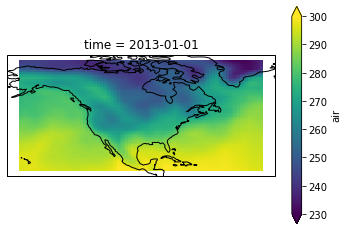

In [11]:
ax = plt.axes(projection=ccrs.PlateCarree())
dr_out.isel(time=0).plot.pcolormesh(ax=ax, vmin=230, vmax=300);
ax.coastlines();

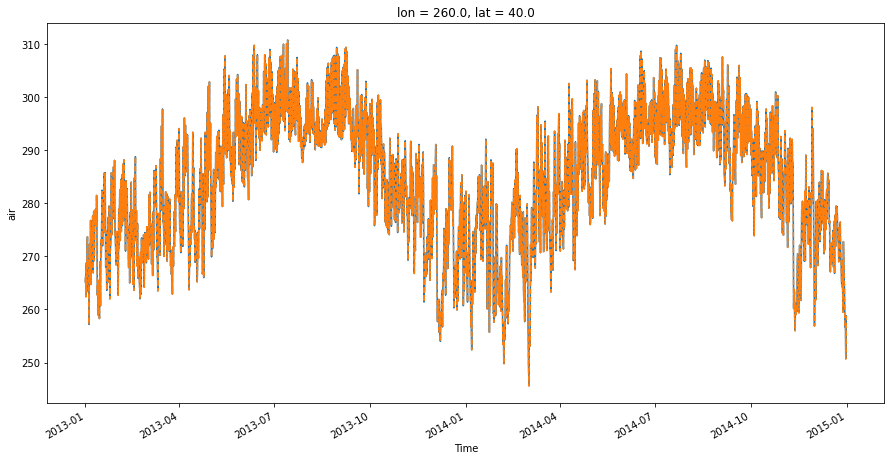

In [12]:
fig, ax = plt.subplots(figsize=(15,7))
dr.sel(lon=260, lat=40).plot(ax=ax)  # input data
dr_out.sel(lon=260, lat=40).plot(ls='--', ax=ax)  # output data

Text(0, 0.5, 'Downscaled Grid')

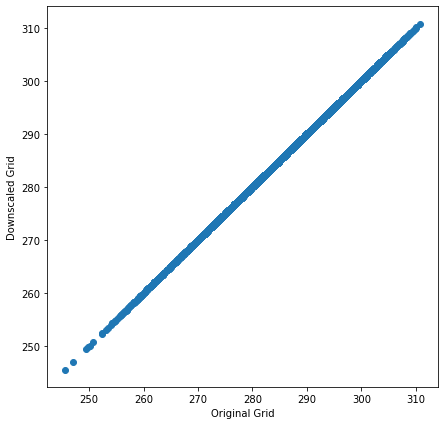

In [13]:
fig, ax = plt.subplots(figsize=(7,7))
plt.scatter(dr.sel(lon=260, lat=40), dr_out.sel(lon=260, lat=40))
ax.set_xlabel('Original Grid')
ax.set_ylabel('Downscaled Grid')

## Cleanup files

ESMF generates a file containing regrid data.  This can be saved and reused to save time for future regridding.  However, if not you can remove it using `xesmf.Regridder.clean_weight_file()`.

In [14]:
ls *.nc

bilinear_25x53_59x87.nc       nearest_s2d_363x360_179x179.nc
bilinear_363x360_179x179.nc   nearest_s2d_363x360_360x720.nc
nearest_s2d_25x53_360x720.nc


In [15]:
regridder.clean_weight_file()
!ls *.nc

Remove file bilinear_25x53_59x87.nc
bilinear_363x360_179x179.nc   nearest_s2d_363x360_179x179.nc
nearest_s2d_25x53_360x720.nc  nearest_s2d_363x360_360x720.nc


# Regrid curvilinear grid

Many data are not on regular lat-lon grids but are instead on [_curvilinear_](https://climatedataguide.ucar.edu/climate-data-tools-and-analysis/regridding-overview) grids.  Many ocean model grids are _curvilinear_ ([see here](https://drclimate.wordpress.com/2018/12/30/data-analysis-and-ocean-model-grids/).  These can be regridded by `xesmf` in very much the same way as _rectilinear_ or regular lat-lon grids above.  The `xesmf` tutorial uses output from RASM to demonstrate regridding a curvilinear grid.  However, here I will use sea ice concentration from the MRI-ESM2 model as an example.

Clicking on the &#9658; beside attributes and looking for the __grid__ attribute will show that the sea ice is on a "native ocean tri-polar grid with 360x363 ocean cells".

In [16]:
filepath = '../siconc_SImon_MRI-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc'
ds = xr.open_dataset(filepath)
ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})  #xesmf only recognizes lon and lat
ds

<xarray.Dataset>
Dimensions:             (bnds: 2, time: 1980, vertices: 4, x: 360, y: 363)
Coordinates:
  * time                (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * y                   (y) float64 -78.0 -77.5 -77.0 ... 149.7 151.8 154.0
  * x                   (x) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
    lat                 (y, x) float64 ...
    lon                 (y, x) float64 ...
    type                |S7 ...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) datetime64[ns] ...
    y_bnds              (y, bnds) float64 ...
    x_bnds              (x, bnds) float64 ...
    vertices_latitude   (y, x, vertices) float64 ...
    vertices_longitude  (y, x, vertices) float64 ...
    siconc              (time, y, x) float32 ...
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-09-03T08:11:37Z
    data_specs_version:     01.00.31
    experiment:             all-forcing simulation of the recent past
    experiment_id:          historical
    external_variables:     areacello
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.MRI.MRI-ESM2...
    grid:                   native ocean tri-polar grid with 360x363 ocean cells
    grid_label:             gn
    history:                2019-09-03T08:11:37Z ; CMOR rewrote data to be co...
    initialization_index:   1
    institution:            Meteorological Research Institute, Tsukuba, Ibara...
    institution_id:         MRI
    mip_era:                CMIP6
    nominal_resolution:     100 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       MRI-ESM2-0
    parent_time_units:      days since 1850-01-01
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  seaIce
    source:                 MRI-ESM2.0 (2017): \naerosol: MASINGAR mk2r4 (TL9...
    source_id:              MRI-ESM2-0
    source_type:            AOGCM AER CHEM
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               SImon
    table_info:             Creation Date:(24 July 2019) MD5:1d2f5276ed1d6eae...
    title:                  MRI-ESM2-0 output prepared for CMIP6
    tracking_id:            hdl:21.14100/af962ff0-13d3-4b8b-b6bc-7b533a373109
    variable_id:            siconc
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MRI is licensed unde...
    cmor_version:           3.5.0

We can plot the data to see what it looks like.  This is clearly not a regular grid.

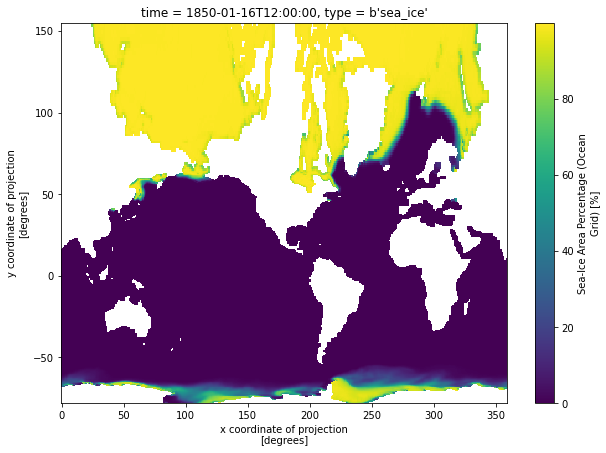

In [17]:
fig, ax = plt.subplots(figsize=(10,7))
ds.siconc[0,:,:].plot(ax=ax)

Plotting a selection of grid-points on a map shows that the grid is regular at middle latitudes in the northern hemisphere and throughout the southern hemisphere, albeit with irregular spacing.  However, the grid is not regular in the northern high latitudes.

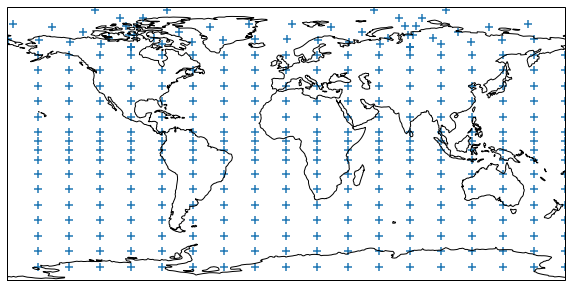

In [18]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.scatter(ds.lon[::20, ::20], ds.lat[::20, ::20], 50, marker='+', transform=ccrs.PlateCarree())
ax.coastlines()

Plotting points north of 50 &#176;N shows the two poles in the northern hemisphere; one over Arctic Canada and one in Siberia.  The third pole of the tri-polar grid is on the Antarctic continent. 

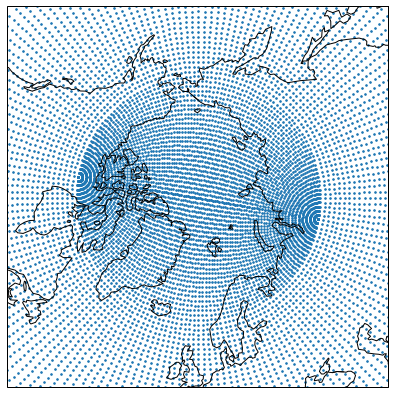

In [19]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180., 50., 90.], ccrs.PlateCarree())
ax.scatter(ds.lon[::2, ::2], ds.lat[::2, ::2], 10, marker='.', transform=ccrs.PlateCarree())
ax.coastlines()

For the purposes of illustration, we will regrid the data to a regular lat-lon grid with 0.5 degree spacing.

In [20]:
ds_out = xr.Dataset({
    'lon': np.linspace(0,359.5,720),
    'lat': np.linspace(-89.5, 89.5, 360)
})
ds_out

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720)
Coordinates:
  * lon      (lon) float64 0.0 0.5 1.0 1.5 2.0 ... 357.5 358.0 358.5 359.0 359.5
  * lat      (lat) float64 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
Data variables:
    *empty*

In [21]:
regridder = xe.Regridder(ds, ds_out, 'nearest_s2d')
regridder

Overwrite existing file: nearest_s2d_363x360_360x720.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       nearest_s2d 
Weight filename:            nearest_s2d_363x360_360x720.nc 
Reuse pre-computed weights? False 
Input grid shape:           (363, 360) 
Output grid shape:          (360, 720) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [22]:
dr_out = regridder(ds.siconc)
dr_out

<xarray.DataArray 'siconc' (time: 1980, lat: 360, lon: 720)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [99.67521667, 99.67521667, 99.67521667, ..., 99.67521667,
         99.67521667, 99.67521667],
        [99.67457581, 99.67457581, 99.67457581, ..., 99.67457581,
         99.67457581, 99.67457581],
        [99.57958221, 99.57958221, 99.57958221, ..., 99.57958221,
         99.57958221, 99.57958221]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [99.7545929 , 99.7545929 , 99.7545929 , ..., 99.7545929 ,
         99.7545929 , 99.7545929 ],
        [99.75737762, 99.75737762, 99.75737762, ..., 99.75737762,
         99.75737762, 99.75737762],
        [99.7122879 , 99.7122879 , 99.7122879 , ..., 99.7122879 ,
         99.7122879 , 99.7122879 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [99.67325592, 99.67325592, 99.67325592, ..., 99.67325592,
         99.67325592, 99.67325592],
        [99.65422058, 99.65422058, 99.65422058, ..., 99.65422058,
         99.65422058, 99.65422058],
        [99.71668243, 99.71668243, 99.71668243, ..., 99.71668243,
         99.71668243, 99.71668243]],

       ...,

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [94.12204742, 94.12204742, 94.12204742, ..., 94.12204742,
         94.12204742, 94.12204742],
        [94.33759308, 94.33759308, 94.33759308, ..., 94.33759308,
         94.33759308, 94.33759308],
        [94.65751648, 94.65751648, 94.65751648, ..., 94.65751648,
         94.65751648, 94.65751648]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [98.36250305, 98.36250305, 98.36250305, ..., 98.36250305,
         98.36250305, 98.36250305],
        [98.51618195, 98.51618195, 98.51618195, ..., 98.51618195,
         98.51618195, 98.51618195],
        [98.33840942, 98.33840942, 98.33840942, ..., 98.33840942,
         98.33840942, 98.33840942]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [99.42391968, 99.42391968, 99.42391968, ..., 99.42391968,
         99.42391968, 99.42391968],
        [99.44567871, 99.44567871, 99.44567871, ..., 99.44567871,
         99.44567871, 99.44567871],
        [99.38023376, 99.38023376, 99.38023376, ..., 99.38023376,
         99.38023376, 99.38023376]]])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
    type     |S7 b'sea_ice'
  * lon      (lon) float64 0.0 0.5 1.0 1.5 2

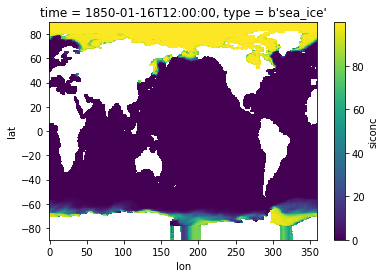

In [23]:
dr_out[0,:,:].plot()

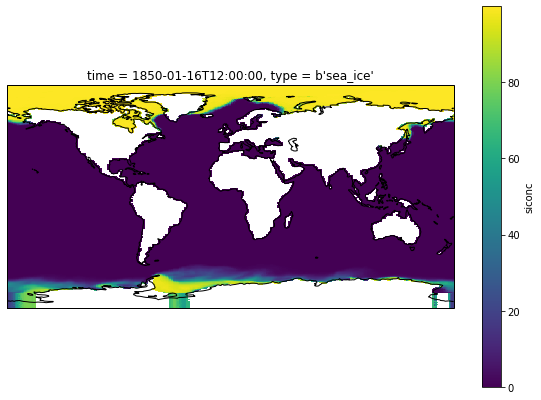

In [24]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
dr_out[0,:,:].plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

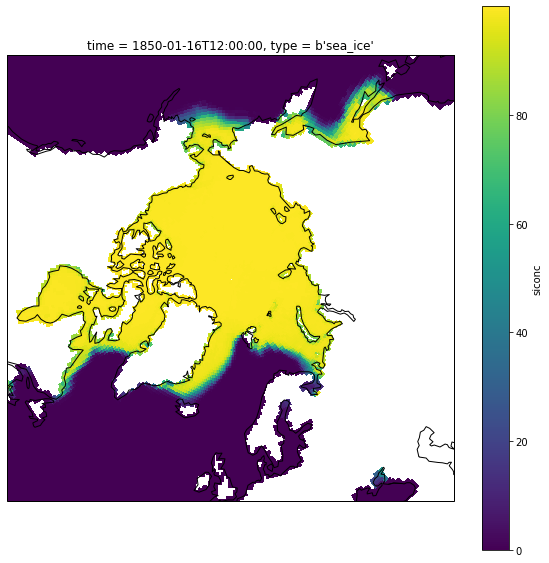

In [25]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180., 180., 50., 90.], ccrs.PlateCarree())
dr_out[0,:,:].plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

It would be nice to be able to regrid these data to an equal area grid such as EASE-Grid 2.0 North.  This makes calculations such as spatial means etc easier.  First we get the latitude longitude 

In [26]:
from apbplotlib.maps import EASE2_North

In [27]:
proj_out = EASE2_North()

In [28]:
proj_tmp = ccrs.PlateCarree()

In [29]:
xmin, xmax = proj_out.x_limits
ymin, ymax = proj_out.y_limits
dx = dy = 50000.
x = np.arange(xmin+dx/2., xmax-dx/2., dx)
y = np.arange(ymin+dy/2., ymax-dy/2., dy)
x2d, y2d = np.meshgrid(x, y)

In [30]:
grid_out = proj_tmp.transform_points(proj_out, x2d, y2d)
lon2d, lat2d = grid_out[:,:,0], grid_out[:,:,1]
lon2d = np.where(lon2d < 0., 360 + lon2d, lon2d)

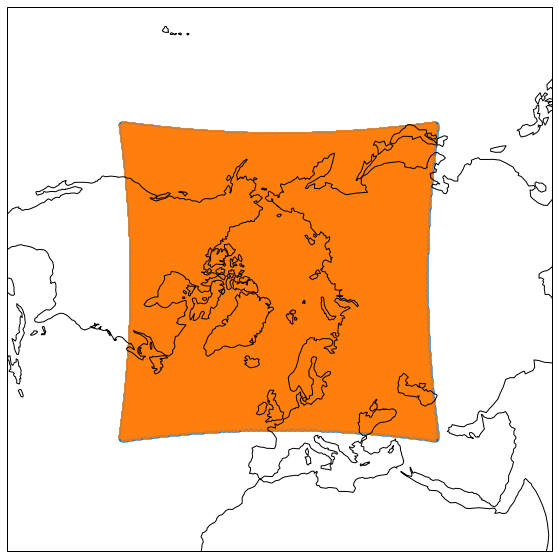

In [31]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180., 180., 20., 90.], ccrs.PlateCarree())
ax.scatter(x2d, y2d, 50, transform=proj_out)
ax.scatter(lon2d, lat2d, 50, marker='+', transform=proj_tmp)
ax.coastlines()

In [36]:
ease2N = xr.Dataset({
    'lon': (['x', 'y'], lon2d), 
    'lat': (['x', 'y'], lat2d),
})
regridder = xe.Regridder(ds, ease2N, 'bilinear')
regridder

/home/apbarret/anaconda3/envs/xesmf_env_test/lib/python3.7/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "


Overwrite existing file: bilinear_363x360_179x179.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_363x360_179x179.nc 
Reuse pre-computed weights? False 
Input grid shape:           (363, 360) 
Output grid shape:          (179, 179) 
Output grid dimension name: ('x', 'y') 
Periodic in longitude?      False

In [37]:
ease2N_siconc = regridder(ds.siconc)
ease2N_siconc

<xarray.DataArray 'siconc' (time: 1980, x: 179, y: 179)>
array([[[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
    type     |S7 b'sea_ice'
    lon      (x, y) float64 315.0 315.3 315.6 316.0 ... 136.0 135.7 135.3 135.0
    lat      (x, y) float64 30.55 30.92 31.28 31.64 ... 32.37 32.01 31.65 31.28
Dimensions without coordinates: x, y
Attributes:
    regrid_method:  bilinear

In [34]:
ease2N_siconc.coords['x'] = x
ease2N_siconc.coords['y'] = y
ease2N_siconc

<xarray.DataArray 'siconc' (time: 1980, x: 179, y: 179)>
array([[[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
    type     |S7 b'sea_ice'
    lon      (x, y) float64 315.0 315.3 315.6 316.0 ... 136.0 135.7 135.3 135.0
    lat      (x, y) float64 30.55 30.92 31.28 31.64 ... 32.37 32.01 31.65 31.28
  * x        (x) float64 -4.475e+06 -4.425e+06 ... 4.375e+06 4.425e+06
  * y        (y) float64 -4.475e+06 -4.425e+06 ... 4.375e+06 4.425e+06
Attributes:
    regrid_method:  bilinear

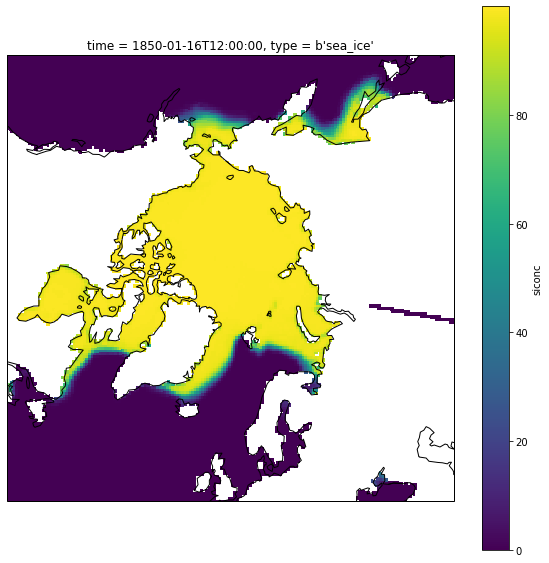

In [35]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180., 180., 50., 90.], ccrs.PlateCarree())
ease2N_siconc[0,:,:].plot(ax=ax, transform=proj_out)
ax.coastlines()

## Try using bare bones ESMF

In [95]:
import ESMF

In [100]:
lat2d.shape

(179, 179)

Initialize source and destination grids

In [103]:
sourcegrid = ESMF.Grid(np.array(ds.lat.T.shape), staggerloc=ESMF.StaggerLoc.CENTER, coord_sys=ESMF.CoordSys.SPH_DEG)
destgrid = ESMF.Grid(np.array(lat2d.T.shape), staggerloc=ESMF.StaggerLoc.CENTER, coord_sys=ESMF.CoordSys.SPH_DEG)

Add coordinates to grids

In [104]:
source_lon = sourcegrid.get_coords(0)
source_lat = sourcegrid.get_coords(1)
source_lon[...] = ds.lon.T
source_lat[...] = ds.lat.T

dest_lon = destgrid.get_coords(0)
dest_lat = destgrid.get_coords(1)
dest_lon[...] = lon2d.T
dest_lat[...] = lat2d.T

Define source and destination fields

In [105]:
sourcefield = ESMF.Field(sourcegrid, name='Source')
destfield = ESMF.Field(destgrid, name='Destination')

Generate regrid object

In [136]:
regrid = ESMF.Regrid(sourcefield, destfield, 
                     regrid_method=ESMF.RegridMethod.BILINEAR,
                     unmapped_action=ESMF.UnmappedAction.IGNORE,)

In [137]:
sourcefield.data[...] = ds.siconc[0,:,:].T.values
destfield = regrid(sourcefield, destfield)

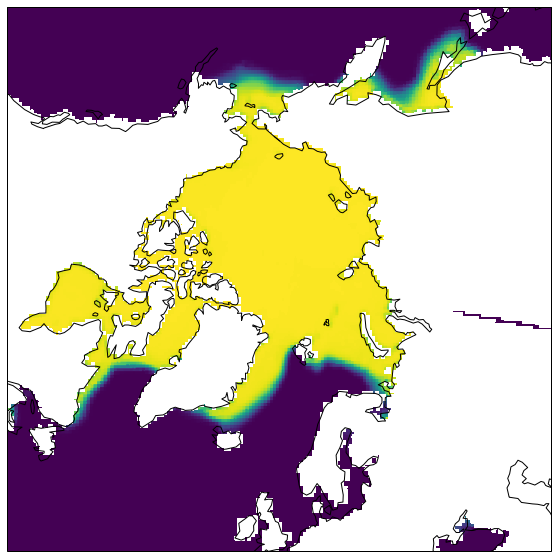

In [138]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180., 180., 50., 90.], ccrs.PlateCarree())
ax.imshow(destfield.data.T, transform=proj_out)
ax.coastlines()

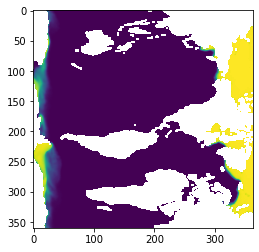

In [120]:
plt.imshow(ds.siconc[0,:,:].T.values)

In [122]:
xr.open_dataset('bilinear_363x360_179x179.nc')

<xarray.Dataset>
Dimensions:  (n_s: 127988)
Dimensions without coordinates: n_s
Data variables:
    S        (n_s) float64 ...
    col      (n_s) int32 ...
    row      (n_s) int32 ...

In [139]:
ds

<xarray.Dataset>
Dimensions:             (bnds: 2, time: 1980, vertices: 4, x: 360, y: 363)
Coordinates:
  * time                (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * y                   (y) float64 -78.0 -77.5 -77.0 ... 149.7 151.8 154.0
  * x                   (x) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
    lat                 (y, x) float64 -78.0 -78.0 -78.0 ... 65.29 64.86 64.43
    lon                 (y, x) float64 80.0 81.0 82.0 83.0 ... 80.0 80.0 80.0
    type                |S7 b'sea_ice'
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) datetime64[ns] 1850-01-01 ... 2015-01-01
    y_bnds              (y, bnds) float64 -78.25 -77.75 -77.75 ... 152.9 155.1
    x_bnds              (x, bnds) float64 -0.5 0.5 0.5 1.5 ... 358.5 358.5 359.5
    vertices_latitude   (y, x, vertices) float64 ...
    vertices_longitude  (y, x, vertices) float64 ...
    siconc              (time, y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-09-03T08:11:37Z
    data_specs_version:     01.00.31
    experiment:             all-forcing simulation of the recent past
    experiment_id:          historical
    external_variables:     areacello
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.MRI.MRI-ESM2...
    grid:                   native ocean tri-polar grid with 360x363 ocean cells
    grid_label:             gn
    history:                2019-09-03T08:11:37Z ; CMOR rewrote data to be co...
    initialization_index:   1
    institution:            Meteorological Research Institute, Tsukuba, Ibara...
    institution_id:         MRI
    mip_era:                CMIP6
    nominal_resolution:     100 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       MRI-ESM2-0
    parent_time_units:      days since 1850-01-01
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  seaIce
    source:                 MRI-ESM2.0 (2017): \naerosol: MASINGAR mk2r4 (TL9...
    source_id:              MRI-ESM2-0
    source_type:            AOGCM AER CHEM
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               SImon
    table_info:             Creation Date:(24 July 2019) MD5:1d2f5276ed1d6eae...
    title:                  MRI-ESM2-0 output prepared for CMIP6
    tracking_id:            hdl:21.14100/af962ff0-13d3-4b8b-b6bc-7b533a373109
    variable_id:            siconc
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MRI is licensed unde...
    cmor_version:           3.5.0